# Compute Demo: Use Rooki to access CMIP6 data

## Overview

Here we use intake-esfg with Rookie to subset and regrid CMIP6 data

**ROOK**: **R**emote **O**perations **O**n **K**limadaten

* Rook: https://github.com/roocs/rook
* Rooki: https://github.com/roocs/rooki
* Clisops: https://github.com/roocs/clisops
* Rook Presentation: https://github.com/cehbrecht/talk-rook-status-kickoff-meeting-2022/blob/main/Rook_C3S2_380_2022-02-11.pdf

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [Knowing OGC services](https://ogcapi.ogc.org/processes/) | Helpful | Understanding of the service interfaces |


- **Time to learn**: 15 minutes

## Init Rooki

In [1]:
import os

os.environ["ROOK_URL"] = "http://rook.dkrz.de/wps"

from rooki import rooki
import xarray as xr

In [2]:
from intake_esgf import ESGFCatalog
import matplotlib.pyplot as plt

In [3]:
cat = ESGFCatalog()
print(cat)  # <-- nothing to see here yet

Perform a search() to populate the catalog.


## Retrieve subset of CMIP6 data

The CMIP6 dataset is identified by a dataset-id. An intake catalog as available to lookup the available datasets:

https://nbviewer.org/github/roocs/rooki/blob/master/notebooks/demo/demo-intake-catalog.ipynb

In [4]:
def keep_ds_id(ds):
    return ds[0].split("|")[0]

In [5]:
cat.search(
    experiment_id=["historical"],
    variable_id=["tos"],
    table_id=["Omon"],
    project=["CMIP6"],
    grid_label=["gn"],
    source_id=[
        "CAMS-CSM1-0",
        "FGOALS-g3",
        "CMCC-CM2-SR5",
        "CNRM-CM6-1",
        "CNRM-ESM2-1",
        "EC-Earth3-Veg",
        "CESM2",
    ],
)
cat.remove_ensembles()
print(cat)

   Searching indices:   0%|          |0/2 [       ?index/s]

Summary information for 11 results:
experiment_id                                          [historical]
mip_era                                                [CMIP6, nan]
activity_drs                                                 [CMIP]
datetime_stop     [nan, 2014-12-16T12:00:00Z, 2014-12-15T12:00:00Z]
table_id                                                     [Omon]
grid_label                                                     [gn]
datetime_start    [1848-10-25T13:00:00Z, 1850-01-16T12:00:00Z, 1...
source_id         [FGOALS-g3, CAMS-CSM1-0, EC-Earth3-Veg, CMCC-C...
member_id                                      [r1i1p1f1, r1i1p1f2]
variable_id                                                   [tos]
institution_id    [CAS, CAMS, EC-Earth-Consortium, CMCC, CNRM-CE...
project                                                     [CMIP6]
dtype: object


In [6]:
collections = cat.df.id.apply(keep_ds_id).to_list()
collections

['CMIP6.CMIP.CAS.FGOALS-g3.historical.r1i1p1f1.Omon.tos.gn.v20191107',
 'CMIP6.CMIP.CAMS.CAMS-CSM1-0.historical.r1i1p1f1.Omon.tos.gn.v20190708',
 'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.r1i1p1f1.Omon.tos.gn.v20211207',
 'CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1.Omon.tos.gn.v20200616',
 'CMIP6.CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.tos.gn.v20181206',
 'CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Omon.tos.gn.v20180917',
 'CMIP6.CMIP.NCAR.CESM2.historical.r1i1p1f1.Omon.tos.gn.v20190308',
 'CMIP6.CMIP.CAS.FGOALS-g3.historical.r1i1p1f1.Omon.tos.gn.v20191107',
 'CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1.Omon.tos.gn.v20200616',
 'CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Omon.tos.gn.v20180917',
 'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.r1i1p1f1.Omon.tos.gn.v20211207']

In [7]:
from rooki import operators as ops

In [8]:
def get_pacific_ocean(dataset_id):
    wf = ops.Regrid(
        ops.Subset(
            ops.Input("tos", [dataset_id]),
            time="1900-01-01/2000-01-31",
            area="100,-20,280,20",
        ),
        method="nearest_s2d",
        grid="2pt5deg",
    )
    resp = wf.orchestrate()
    if resp.ok:
        print(f"{resp.size_in_mb=}")
        ds = resp.datasets()[0]
    else:
        ds = xr.Dataset()
    return ds

### Open Dataset with xarray

In [9]:
sst_data = {dset: get_pacific_ocean(dset) for dset in collections}

resp.size_in_mb=47.618300437927246
resp.size_in_mb=47.61820125579834
resp.size_in_mb=47.622283935546875
resp.size_in_mb=47.6201171875
resp.size_in_mb=47.621718406677246
resp.size_in_mb=47.61574363708496
resp.size_in_mb=47.61813259124756
resp.size_in_mb=47.622283935546875
resp.size_in_mb=47.621886253356934


### Plot CMIP6 Dataset

In [10]:
import xeofs as xe
import numpy.polynomial.polynomial as poly
import numpy as np

In [11]:
def compute_alpha(pc1, pc2):
    coefs = poly.polyfit(pc1, pc2, deg=2)
    xfit = np.arange(pc1.min(), pc1.max() + 0.1, 0.1)
    fit = poly.polyval(xfit, coefs)
    return coefs[-1], xfit, fit


def correction_factor(model):
    _eofs = model.components()
    _subset = dict(lat=slice(-5, 5), lon=slice(140, 180))
    corr_factor = np.zeros(2)
    corr_factor[0] = 1 if _eofs.sel(mode=1, **_subset).mean() > 0 else -1
    corr_factor[1] = 1 if _eofs.sel(mode=2, **_subset).mean() > 0 else -1
    return xr.DataArray(corr_factor, coords=[("mode", [1, 2])])


def compute_index(ds):
    tos = ds.tos.sel(lat=slice(-20, 20), lon=slice(100, 280))
    tos_anom = tos.groupby("time.month").apply(lambda x: x - x.mean("time"))

    # Compute Eofs
    model = xe.models.EOF(n_modes=2, use_coslat=True)
    model.fit(tos_anom, dim="time")
    corr_factor = correction_factor(model)
    # eofs = s_model.components()
    scale_factor = model.singular_values() / np.sqrt(model.explained_variance())
    pcs = (
        model.scores().convert_calendar("standard", align_on="date")
        * scale_factor
        * corr_factor
    )

    pc1 = pcs.sel(mode=1)
    pc1 = pc1.sel(time=pc1.time.dt.month.isin([12, 1, 2]))
    pc1 = pc1.resample(time="QS-DEC").mean().dropna("time")

    pc2 = pcs.sel(mode=2)
    pc2 = pc2.sel(time=pc2.time.dt.month.isin([12, 1, 2]))
    pc2 = pc2.resample(time="QS-DEC").mean().dropna("time")

    alpha, xfit, fit = compute_alpha(pc1, pc2)

    # Do a 45degree rotation
    # eindex = (pcs.sel(mode=1) - pcs.sel(mode=2))/(2**(1/2))
    # cindex = (pcs.sel(mode=1) + pcs.sel(mode=2))/(2**(1/2))

    return pc1, pc2, alpha, xfit, fit

In [12]:
alpha_fits = {}
for key, item in sst_data.items():
    if len(item.variables) == 0:
        continue
    alpha_fits[key] = compute_index(item)

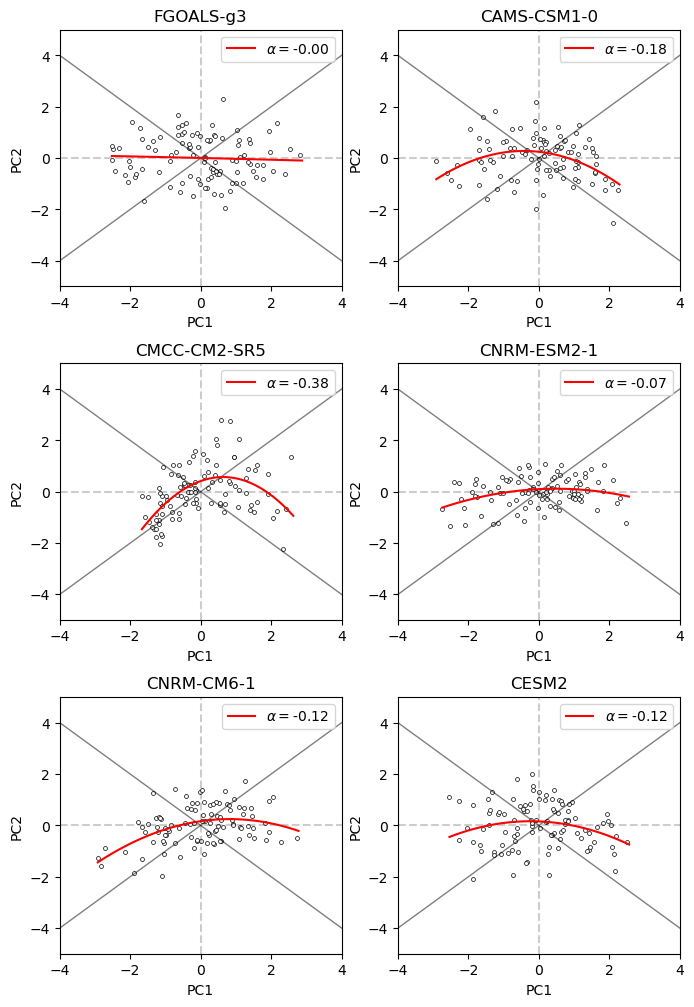

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
axs = axs.ravel()
for num, (ds, (pc1, pc2, alpha, xfit, fit)) in enumerate(alpha_fits.items()):
    ax = axs[num]
    ax.axhline(0, color="k", linestyle="--", alpha=0.2)
    ax.axvline(0, color="k", linestyle="--", alpha=0.2)

    # draw a line 45 degrees
    x = np.linspace(-6, 6, 100)
    y = x
    ax.plot(x, y, color="k", alpha=0.5, lw=1)
    ax.plot(-x, y, color="k", alpha=0.5, lw=1)

    ax.scatter(
        pc1,
        pc2,
        s=8,
        marker="o",
        c="w",
        edgecolors="k",
        linewidths=0.5,
    )

    ax.plot(xfit, fit, c="r", label=f"$\\alpha=${alpha:.2f}")

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    ax.set_title(ds.split(".")[3])

    ax.set_xlim(-4, 4)
    ax.set_ylim(-5, 5)
    ax.legend()
fig.subplots_adjust(hspace=0.3)

## Summary
In this notebook, we used the Rooki Python client to retrieve a subset of a CMIP6 dataset. The operations are executed remotely on a Rook subsetting service (using OGC API and xarray/clisops). The dataset is plotted and a provenance document is shown. We also showed that remote operators can be chained to be executed in a single workflow operation.

### What's next?

This service is used by the European Copernicus Climate Data Store. 

We need to figure out how this service can be used in the new ESGF: 
* where will it be deployed? 
* how can it be integrated in the ESGF search (STAC catalogs, ...)
* ???

## Resources and references
- [Roocs on GitHub](https://github.com/roocs)
- [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/)
- [STAC](https://stacspec.org/en)